In [1]:
import librosa
import numpy
import pandas
import requests
import seaborn
import sklearn
import tensorflow

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"]
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg


In [3]:
# Filter dataframe to include only data from marsberg
dataframe = dataframe[dataframe["environment"] == "marsberg"]

In [4]:
# Generate MFCCs for each recording
def preprocess(dataframe):
    features = []
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc = librosa.feature.mfcc(y=audio, n_mfcc=24, sr=sample_rate)
        features.append(numpy.mean(mfcc.T, axis=0))
        
    dataframe["features"] = features
    
    return dataframe

dataframe = preprocess(dataframe)

71it [01:14,  1.04s/it]


In [5]:
# Prepare and split data for training
x = numpy.array(dataframe["features"].tolist())
y = numpy.array(dataframe["label"].tolist())

x = numpy.expand_dims(x, axis=2)

label_encoder = sklearn.preprocessing.LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.15, random_state=2)
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.15, random_state=2)

print(x_train.shape, x_test.shape, x_val.shape)

(51, 24, 1) (11, 24, 1) (9, 24, 1)


In [6]:
# Configure, compile, and fit model
input_shape=(24, 1)
model = keras.Sequential()
model.add(LSTM(40,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs=72, validation_data=(x_val, y_val), shuffle=False)

2022-09-19 18:26:28.225271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 80)                3280      
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0

In [7]:
# Calculate accuracy on test dataset
test_accuracy=model.evaluate(x_test, y_test, verbose=0)
print(test_accuracy[1])

1.0


1/1 [==============================] - 0s 475ms/step
[[3 0 0 0 0]
 [0 2 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 4]]


<AxesSubplot:>

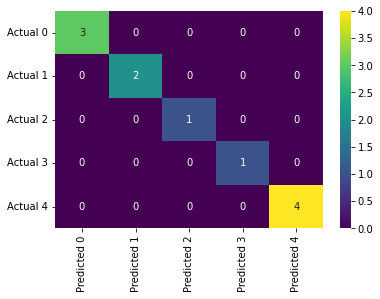

In [8]:
# Generate confusion matrix
y_true, y_pred = numpy.argmax(y_test, axis=1), numpy.argmax(model.predict(x_test), axis=1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

print(confusion_matrix)

def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pandas.DataFrame(sklearn.metrics.confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0) 
    return plot

confusion_matrix_plot(y_true, y_pred)